Here I will try to explain GPR (Gaussian Process Regression) for some toy function and our task

Firstly, let us consider some toy function

To be visually interpreted we will consider 1-dim problem (one input, one output)

In [260]:
# Import needed python libraries 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Toy Function

# Generate Data Smples

We consider the model y = f(x) + ε, where ε∼N(0,σn).
<br>
Here f does not need to be a linear function of x.

For examle, let us consider the next function:
<br>
$f(x) = sin(4*\pi*x)+sin(7*\pi*x)$ 

Text(0.5, 0, 'x')

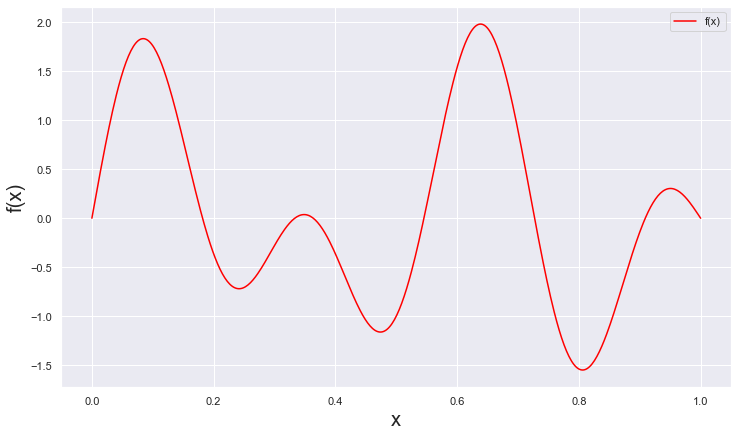

In [215]:
# Dimension
d = 1

# Number of samples (training set)
n = 500

# Input data (training set) 
x = np.linspace(0,1,n)

# Define f function
def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x)
    return(f)

f = f(x)

# Plot function f
plt.rcParams['figure.figsize'] = [12, 7]
sns.lineplot(x=x, y=f, color='red',label='f(x)')
plt.ylabel('f(x)', fontsize=20)
plt.xlabel('x', fontsize=20)

Then, we generate some training sample observations (output data)

Text(0.5, 0, 'x')

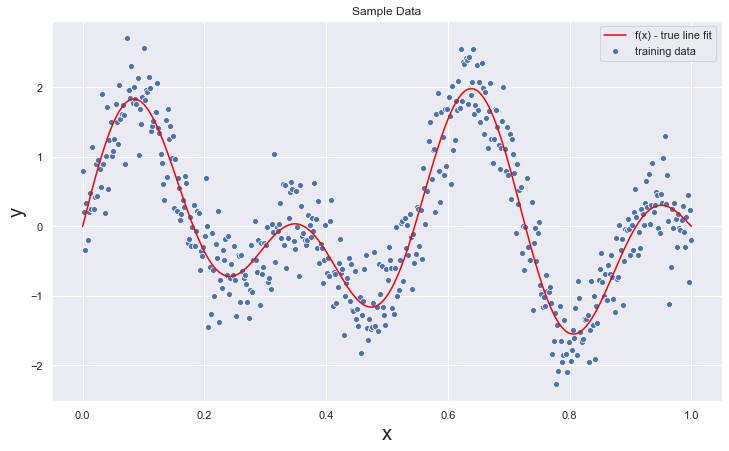

In [216]:
# Error standard deviation
sigma_n = 0.4

# Error
epsilon = np.random.normal(0,sigma_n,n)

# Observed target variable (training set)
y = f + epsilon

# Visualization of the sample data

plt.rcParams['figure.figsize'] = [12, 7]
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, label='training data', ax=ax)
sns.lineplot(x=x, y=f, color='red', label='f(x) - true line fit', ax=ax)
ax.set(title='Sample Data')
plt.ylabel('y', fontsize=20)
plt.xlabel('x', fontsize=20)

#### Now we consider test data points on which we want to generate predictions
<br>
Let us denote input test point as $x_*$

In [217]:
# We propose 100 new sample
n_star = 100

# Input test points which we want to predict
x_star = np.linspace(0,1,n_star)

# Kernel Function

To go further, here it is needed to explain kernel function.

Recall that a gaussian process is completely specified by its mean function and covariance (we usually take the mean equal to zero, although it is not necessary)

Mean value is constructed from a priori given deterministic function
<br>
$\mu$ = {$\mu_{i}$} = {$\mu$($x_{i}$)}

Covariance matrix is constructed from covariance function
<br>
K = {$K_{ij}$} = {K($x_{i}$; $x_{j}$)} 

Covariance function characterizes covariance between points in the
process
<br>
K(x, $x^{'}$) = cov(f(x), f($x^{'}$)) = E(f(x) - $\mu$(x)) (f($x^{'}$) - $\mu$($x^{'}$))

A common choice is the squared exponential function (There are a lot of other choice, but here we consiter that):
$$cov(f(x_{p}),f(x_{q}))= k_{\sigma_{f},ℓ} (x_{p},x_{q}) = \sigma_{f} exp( − \frac{1}{2ℓ^{2}}||x_{p} - x_{q}||^{2})$$ 
<br>
where $\sigma_{f}$,ℓ>0 are hyperparameters.
<br>
$\sigma_f$ - marginal function variance
<br>
ℓ - lengthscale 

Observe that the covariance between two samples are modeled as a function of the inputs!!!

Once the mean and covariance functions are defined, everything else about GPs follows from the basic rules of probability applied to multivariate Gaussians

In [218]:
def kernel_function(xp, xq, sigma_f=1, l=1):
    """Define squared exponential kernel function."""
    kernel = sigma_f * np.exp(-(np.linalg.norm(xp-xq)**2)/(2 * l**2))
    return kernel

# Compute Covariance Matrices

A key observation, is that the specification of the covariance function implies a distribution over functions.

Let us denote by
<br>
K(X,X)∈$M_{n}$(R)
<br>
K($X_{*}$, X)∈$M_{n_*xn}$(R)
<br>
K($X_{*}$,$X_{*}$)∈$M_{n_*}$(R)
<br>
the covariance matrices applies to x and $x_{*}$

In [219]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(X, X) 
        - K_star = K(X_*, X)
        - K_star2 = K(X_*, X_*)
    """
    
    n = x.shape[0]
    n_star = x_star.shape[0]
    
    K = [kernel_function(i, j, sigma_f = sigma_f, l=l) for (i,j) in itertools.product(x, x)]
    K = np.array(K).reshape(n,n)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]
    K_star = np.array(K_star).reshape(n_star, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]
    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    return (K, K_star, K_star2)

We compute the covariance matrices using the function above
<br>
Here we will put our hyperparameters:
<br>
$\sigma_{f}$ = 2,  ℓ = 0.1 

Later, it will be explaned how we have to optimize our hyperparameters to recive better model

In [220]:
l = 0.1
sigma_f = 2

K, K_star, K_star2 = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

print('check shape of K:', K.shape)
print('check shape of K_star:', K_star.shape)
print('check shape of K_star2:', K_star2.shape)

check shape of K: (500, 500)
check shape of K_star: (100, 500)
check shape of K_star2: (100, 100)


# Joint Distribution


To be understanding:
<br>
We have training data set: $S_{m}$={X,y}={($x_{i}$, $y_{i}$)}

Model:
<br>
$y_{i}$ = f($x_{i}$) +  $\epsilon$
<br>
f∼GP(.|0,K)
<br>
$\epsilon$∼N(0,$\sigma_{n}$)

prior:
<br>
p(f) = N(f|0,K)

likelihood (noise model):
<br>
p(y|f) = N(y|f,$\sigma^{2}I_m$)

marginal likelihood:
<br>
p(y) = $\int$ p(y|f)p(f)df = N(0, K+$\sigma^{2}I_m$)


Let us denote input test point as $x_{*}$, and output:
<br>
$y_{*}$ = $f_{*}$ + $\epsilon_{*}$, $f_{*}$ = $f(x_*)$

Consider joint training and test(prediction) marginal likelihood:
<br>
$(\begin{array}{c} y \\ f_* \end{array})$ ∼ N(0,C) \
where C = $\begin{pmatrix}
  K + \sigma^2I & K_*\\ 
  K_*^T & K_{**}
\end{pmatrix}$)

Note that we need to add $\sigma^{2}I_m$ the term to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise)

We now compute the matrix C


In [221]:
a = np.concatenate((K+(sigma_n**2)*np.eye(n), K_star), axis=0)
a.shape

(600, 500)

In [222]:
b = np.concatenate((K_star.T, K_star2), axis=0)
b.shape

(600, 100)

In [223]:
C = np.concatenate((a, b), axis=1)
C.shape

(600, 600)

In [224]:
# Check dimension
print(C.shape == (n+n_star, n+n_star))

# Verify that C is symetric
print(np.all(C.T == C))

True
True


# Prior Distribution

From the consistency requirement of gaussian processes we know that the prior distribution for $f_*$ is N(0, $K_{**}$)

Like we said above, once the mean and covariance functions are defined, everything else about GPs follows from the basic rules of probability applied to multivariate Gaussians

Let us visualize some sample functions from this prior:

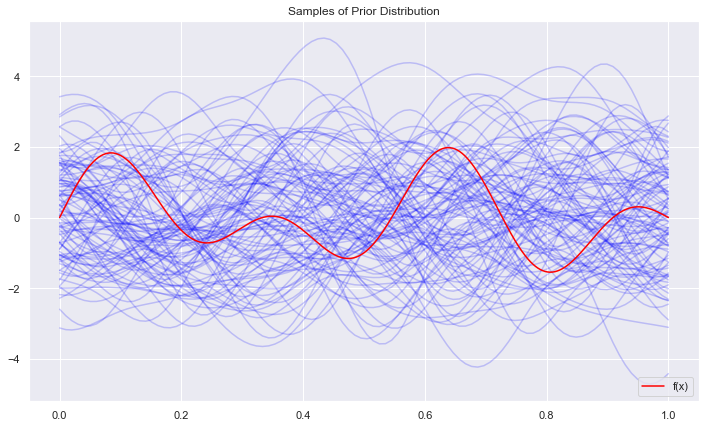

In [225]:
fig, ax = plt.subplots()

for i in range(0,100):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax)
    
# Plot "true" line fit.
sns.lineplot(x=x, y=f, color='red', label='f(x)', ax=ax)
ax.set(title='Samples of Prior Distribution')
ax.legend(loc='lower right');

# Conditional Distribution

To get the posterior distribution over functions we need to restrict joint prior distribution to contain only those functions which agree with the observed data points, that is, we are interested in computing $f_*$|X,y,$X_*$.

We can show that:
<br>
p($f_*$|X,y,$X_*$) = N($f_*$|$\mu_*$, $\sigma_*$)
<br>
where:
<br>
$\mu_*$ = $K_*[K + \sigma_n^2 I]^{-1}$y, $\mu_*$ ∈ $R^{n_*}$ 
<br>
$\sigma_*$ = $K_{**}$ - $K_*[K + \sigma_n^2 I]^{-1}K_*^T$

Now we can calculate the parameters of the posterior distribution:

In [226]:
def compute_gpr_parameters(K, K_star, K_star2, sigma_n):
    """Compute gaussian regression parameters."""
    
    n = K.shape[0]
    
    # Mean
    mean_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    
    # Covariance
    sigma_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (mean_star, sigma_star)

In [227]:
mean_star, sigma_star = compute_gpr_parameters(K, K_star, K_star2, sigma_n) 

Here we can visualize the covariance components to better understand how it influence of our results

Text(0.5, 1.0, 'Components of the Covariance Matrix sigma_star')

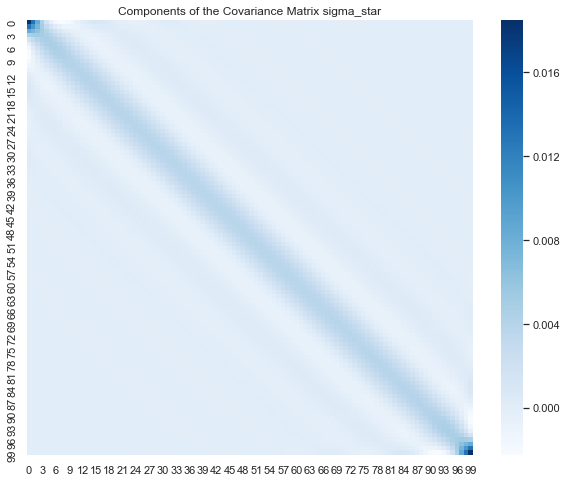

In [228]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=sigma_star, cmap='Blues', ax=ax)
ax.set_title('Components of the Covariance Matrix sigma_star')

#  Posterior distribution

Now we will sample from the posterior distribution:

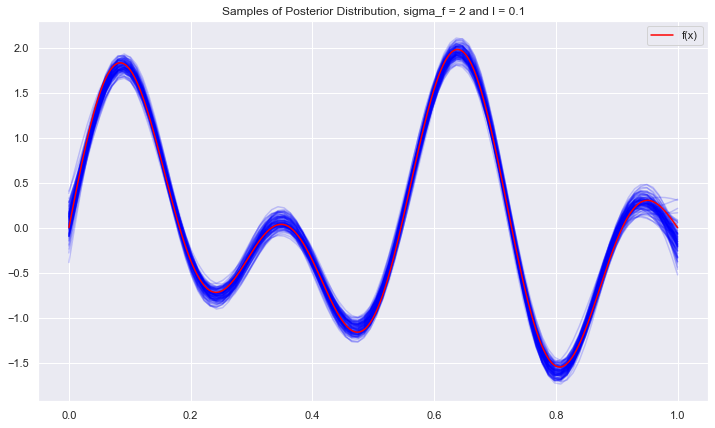

In [229]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_star.squeeze(), cov=sigma_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color='red', label = 'f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

# Hyperparameters

Now we will consider the effect of the hyperparamete of the kernel function defined above.
<br>
$\sigma_f$ - marginal function variance - describes the amplitude of the function.
<br>
ℓ -  lengthscale - describe how far the points interact.


Let us see some concrete examples if we choose different hyperparameters

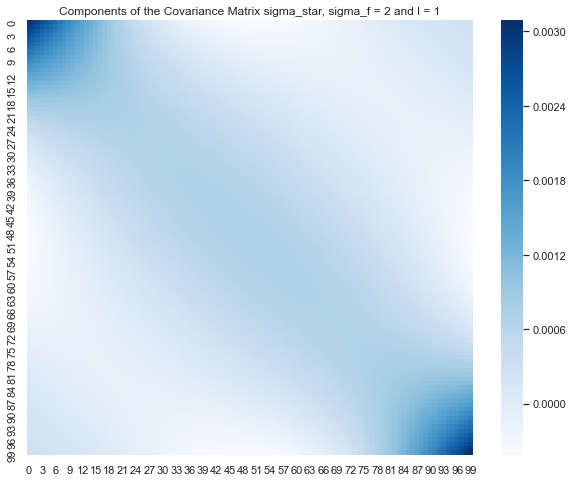

In [230]:
# We increase l 

l = 1
sigma_f = 2

# Compute covariance matrices. 
K, K_star, K_star2 = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

# Compute gaussian process parameters. 
mean_star, sigma_star = compute_gpr_parameters(K, K_star, K_star2, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=sigma_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix sigma_star, sigma_f = {sigma_f} and l = {l}');


In this case (we increase ℓ) the values of the posterior covariance matrix are not that localized. This means that we expect points far away can still have some interaction, i.e. the fit becomes more global. 

Let us plot the resulting fit:

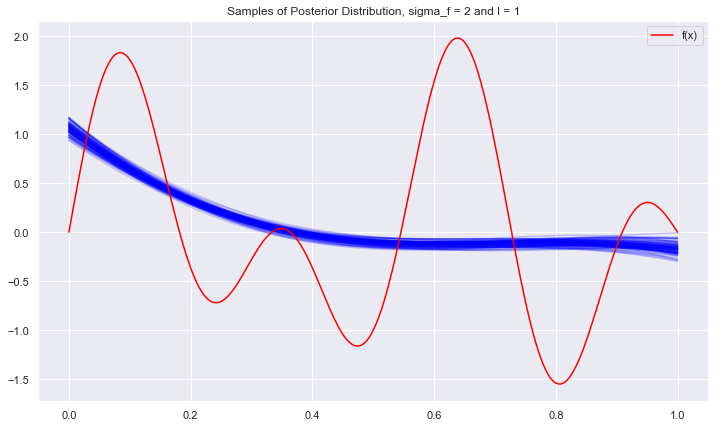

In [231]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_star.squeeze(), cov=sigma_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color='red', label='f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

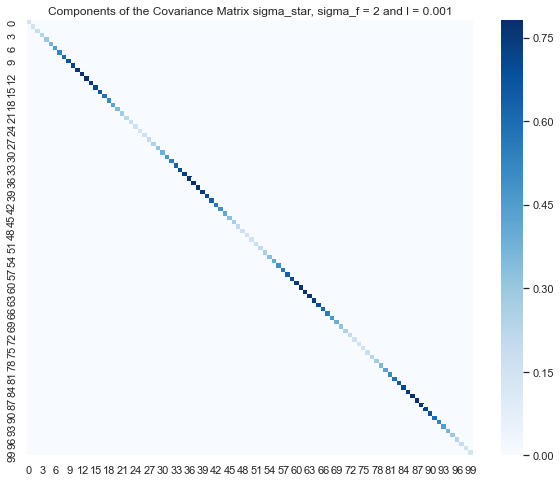

In [232]:
# We decrease l

l = 0.001
sigma_f = 2

# Compute covariance matrices. 
K, K_star, K_star2 = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

# Compute gaussian process parameters. 
mean_star, sigma_star = compute_gpr_parameters(K, K_star, K_star2, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=sigma_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix sigma_star, sigma_f = {sigma_f} and l = {l}');

In contrast, we see that for these set of hyperparameters the higher values of the posterior covariance matrix are concentrated along the diagonal. This means that we expect points far away to have no effect on each other, i.e. the fit becomes more local. 

Let us plot the resulting fit:

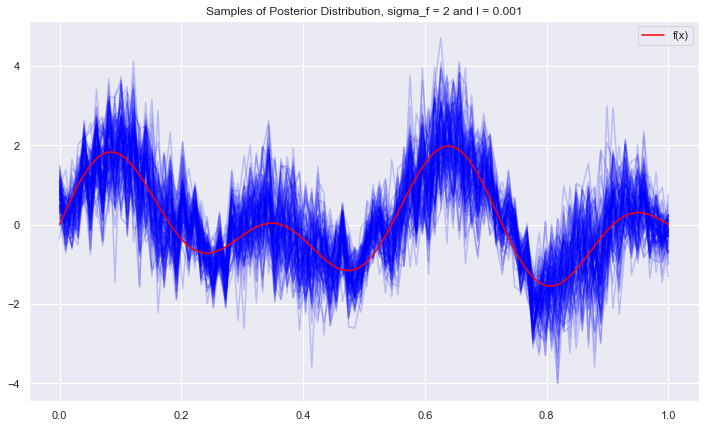

In [233]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_star.squeeze(), cov=sigma_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color='red', label='f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

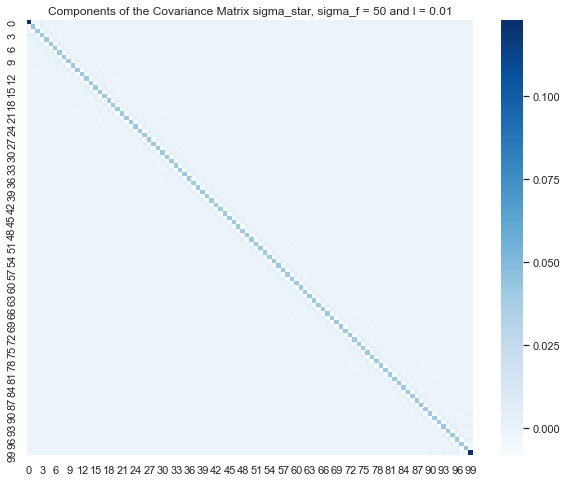

In [234]:
# We increase sigma_f

l = 0.01
sigma_f = 50

# Compute covariance matrices. 
K, K_star, K_star2 = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

# Compute gaussian process parameters. 
mean_star, sigma_star = compute_gpr_parameters(K, K_star, K_star2, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=sigma_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix sigma_star, sigma_f = {sigma_f} and l = {l}');

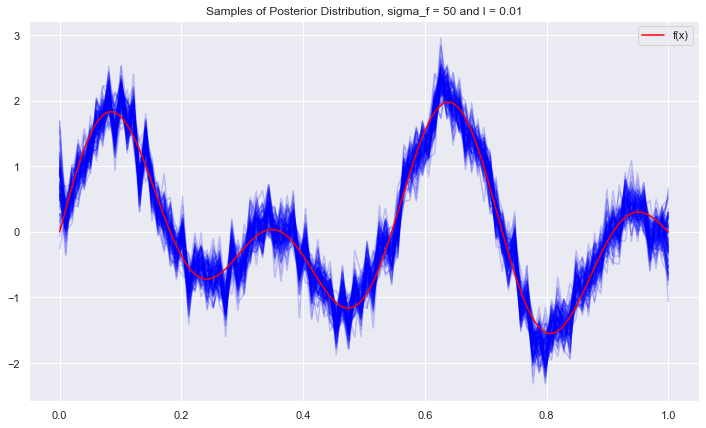

In [235]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_star.squeeze(), cov=sigma_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color='red', label='f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

Advantage of the probabilistic GP framework - ability to choose
hyperparameters and covariances directly from the training data\
To choose hyperparameters we have to maximize the marginal likelihood 

------------

# Our task

Here we will consider data-driven GPR model using historical data from our network.
<br>
Like with the toy function we will consider 1-dim problem (one input, one output) to be visually interpreted.
We consider data from network where load in node 8 is decrease 50% and in that node is include RS (P_max=300MW)
<br>
input = active power of RS in node 8
<br>
output = voltage of node 8

In [236]:
import pandas as pd

df = pd.read_csv('Vm_changel8.csv')
df.head()

,Unnamed: 0,Vm_bus5,Vm_bus6,Vm_bus8,Va_bus5 - Va_bus7,Va_bus5 - Va_bus4,Va_bus6 - Va_bus4,Va_bus6 - Va_bus8,Va_bus8 - Va_bus7,Va_bus8 - Va_bus9,P_rs8
0,0,0.950639,0.953882,0.974744,-0.604375,-1.211128,-1.930093,-5.044268,2.609256,-1.111673,252.255017
1,1,0.919592,0.928374,0.942604,0.114944,-1.703451,-1.488982,-6.288791,6.087464,-0.530740,347.337019
2,2,0.951202,0.954331,0.975244,-0.629916,-1.195572,-1.945475,-5.008867,2.499225,-1.129822,248.937405
3,3,0.932271,0.936865,0.941414,-2.560244,-0.260093,-3.020625,-3.352891,-4.185417,-2.217532,51.696180
4,4,0.956266,0.957976,0.977038,-1.285540,-0.830232,-2.330633,-4.249418,-0.090303,-1.553779,168.916698


Text(0, 0.5, 'Vm_bus8')

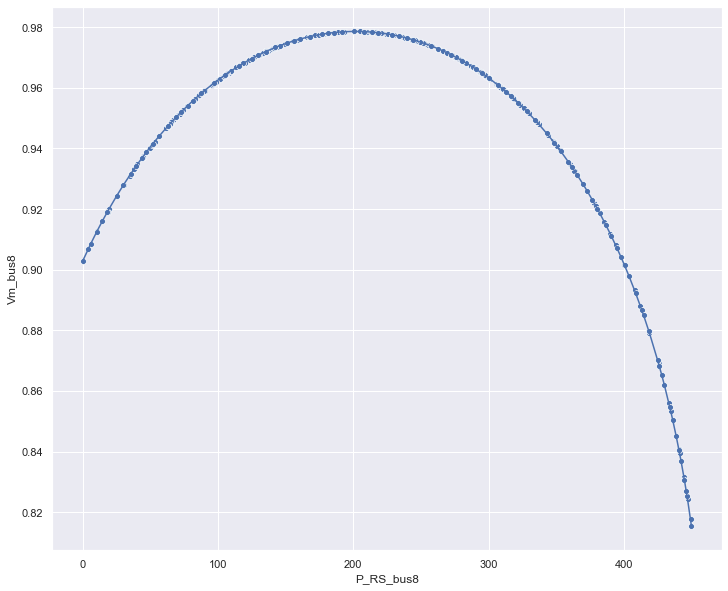

In [237]:
n1 = 350 
n2 = 400

# Dimension
d = 1

# Number of samples (training set)
n = 350
# Number of samples (test set)
n_star = 50


y = df['Vm_bus8'].iloc[:n1]
y = y.to_numpy()

y_test = df['Vm_bus8'].iloc[n1:n2]
y_test = y_test.to_numpy()

x = df['P_rs8'].iloc[:n1]
x = x.to_numpy()

x_star = df['P_rs8'].iloc[n1:n2]
x_star = x_star.to_numpy()

# Plot training data

index = np.arange(1,81)
plt.figure(figsize=(12,10))

sns.lineplot(x=x.ravel(), y=y)
sns.scatterplot(x=x.ravel(), y=y)
plt.xlabel('P_RS_bus8')
plt.ylabel('Vm_bus8')

In [238]:
def kernel_function(xp, xq, sigma_f=1, l=1):
    """Define squared exponential kernel function."""
    kernel = sigma_f * np.exp(-(np.linalg.norm(xp-xq)**2)/(2 * l**2))
    return kernel

In [239]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(X, X) 
        - K_star = K(X_*, X)
        - K_star2 = K(X_*, X_*)
    """
    
    n = x.shape[0]
    n_star = x_star.shape[0]
    
    K = [kernel_function(i, j, sigma_f = sigma_f, l=l) for (i,j) in itertools.product(x, x)]
    K = np.array(K).reshape(n,n)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]
    K_star = np.array(K_star).reshape(n_star, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]
    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    return (K, K_star, K_star2)

In [240]:
sigma_f = 0.647**2
l = 630

K, K_star, K_star2 = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

print('check shape of K:', K.shape)
print('check shape of K_star:', K_star.shape)
print('check shape of K_star2:', K_star2.shape)

check shape of K: (350, 350)
check shape of K_star: (50, 350)
check shape of K_star2: (50, 50)


Here I will use scikit GPR package to determine hypermeters of kernel function to maximize the marginal likelihood

In [159]:
# x = pd.DataFrame(x)
# y = pd.DataFrame(y)

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# sigma_f=1
# sugma_n = 0.2 
# kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-10, 1e10)) \
#         * RBF(length_scale=l, length_scale_bounds=(1e-10, 1e10))

# gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2,n_restarts_optimizer=15,random_state=0)
# gp.fit(x,y)
# print(gp.kernel_)

C:\Users\MILE\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.647**2 * RBF(length_scale=630)


In [241]:
a = np.concatenate((K+(sigma_n**2)*np.eye(n), K_star), axis=0)
print(a.shape)
b = np.concatenate((K_star.T, K_star2), axis=0)
print(b.shape)
C = np.concatenate((a, b), axis=1)
print(C.shape)

# Check dimension
print(C.shape == (n+n_star, n+n_star))

# Verify that C is symetric
print(np.all(C.T == C))

(400, 350)
(400, 50)
(400, 400)
True
True


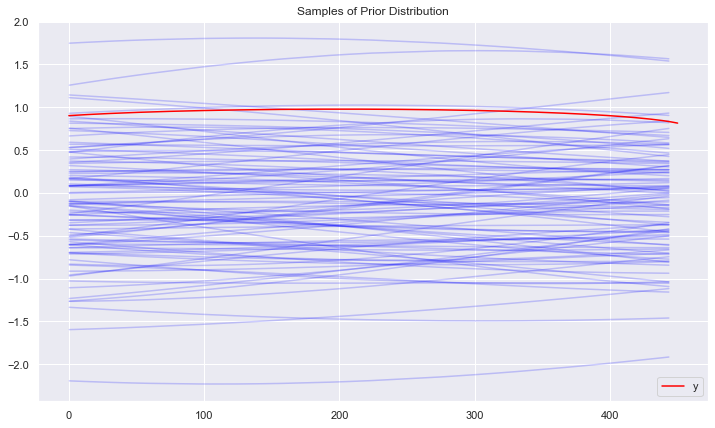

In [242]:
# Prior distribution sampling
fig, ax = plt.subplots()

for i in range(0,100):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax)
    
# Plot "true" line fit.
sns.lineplot(x=x, y=y, color='red', label='y', ax=ax)
ax.set(title='Samples of Prior Distribution')
ax.legend(loc='lower right');

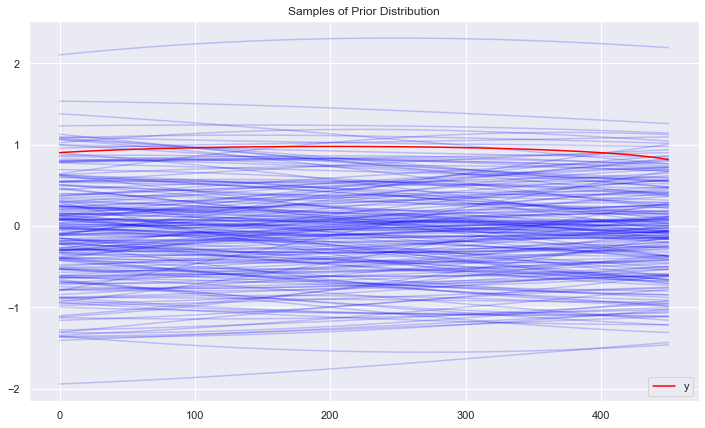

In [252]:
# Prior distribution sampling of training data
fig, ax = plt.subplots()

for i in range(0,200):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=np.zeros(n), cov=K)
    # Plot function.
    sns.lineplot(x=x, y=z_star, color='blue', alpha=0.2, ax=ax)
    
# Plot "true" line fit.
sns.lineplot(x=x, y=y, color='red', label='y', ax=ax)
ax.set(title='Samples of Prior Distribution')
ax.legend(loc='lower right');

## Here we will see 2 diferent results regarding to input noise

### 1. if we chose variance sigma_n=0.1 

In [243]:
sigma_n = 0.1

def compute_gpr_parameters(K, K_star, K_star2, sigma_n):
    """Compute gaussian regression parameters."""
    
    n = K.shape[0]
    
    # Mean
    mean_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    
    # Covariance
    sigma_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (mean_star, sigma_star)

mean_star, sigma_star = compute_gpr_parameters(K, K_star, K_star2, sigma_n) 

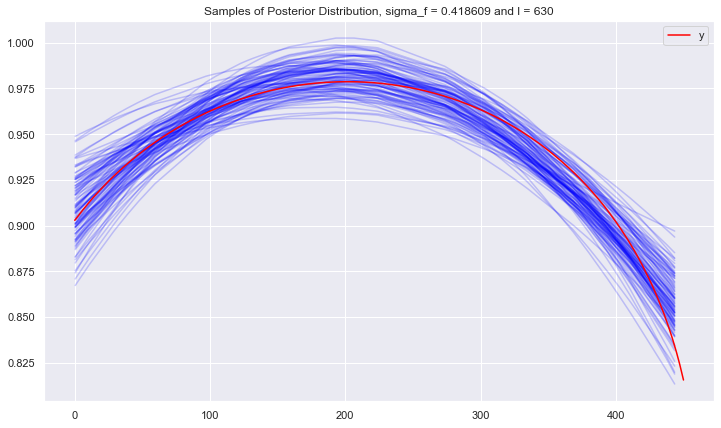

In [244]:
# Prior distribution sampling

fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_star.squeeze(), cov=sigma_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=y, color='red', label = 'y', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

Here I tryed to visualize reletionship between predicted observations (from GPR model) and real data (from physical model of our network).
<br>
Our predicted observations presented distribution with the mean like best prediction and 95% confident level ($\pm$ 2 standard deviation) or uncertainty 

Text(0.5, 0, 'window interval with prediction of 50 observations')

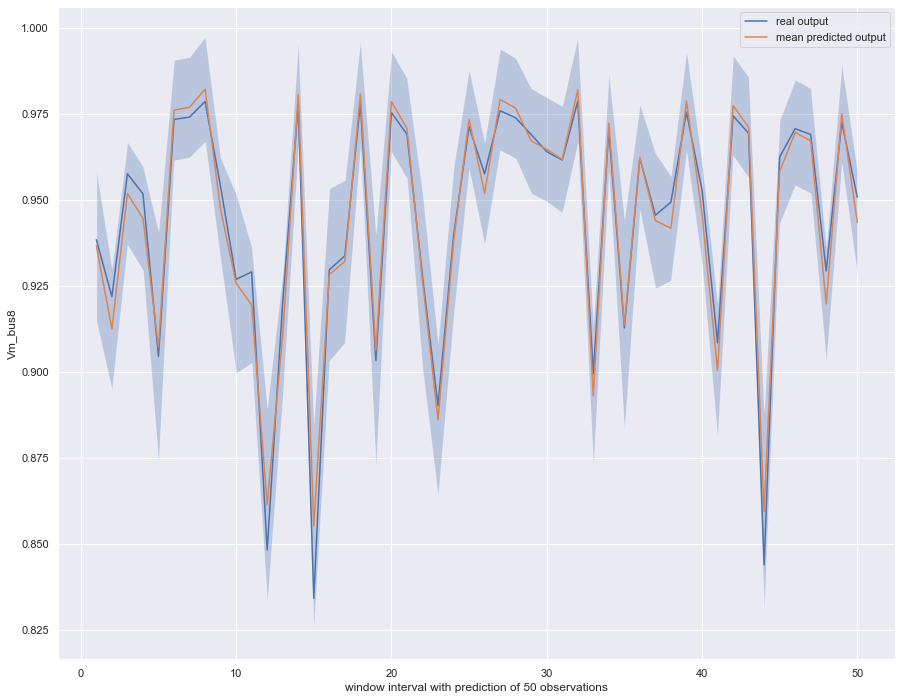

In [245]:
std = np.diag(sigma_star)
std = np.sqrt(std)
std

plt.figure(figsize=(15,12))

plt.plot(np.arange(1,51),  y_test, label='real output')
plt.plot(np.arange(1,51), mean_star, label='mean predicted output')
plt.fill_between(np.arange(1,51), mean_star.ravel() + 2*std, mean_star.ravel()-2*std, alpha=0.3)
plt.legend()
plt.ylabel('Vm_bus8')
plt.xlabel('window interval with prediction of 50 observations')

###  2. if we chose variance sigma_n=0.3

In [246]:
sigma_n = 0.3

def compute_gpr_parameters(K, K_star, K_star2, sigma_n):
    """Compute gaussian regression parameters."""
    
    n = K.shape[0]
    
    # Mean
    mean_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    
    # Covariance
    sigma_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (mean_star, sigma_star)

mean_star, sigma_star = compute_gpr_parameters(K, K_star, K_star2, sigma_n) 

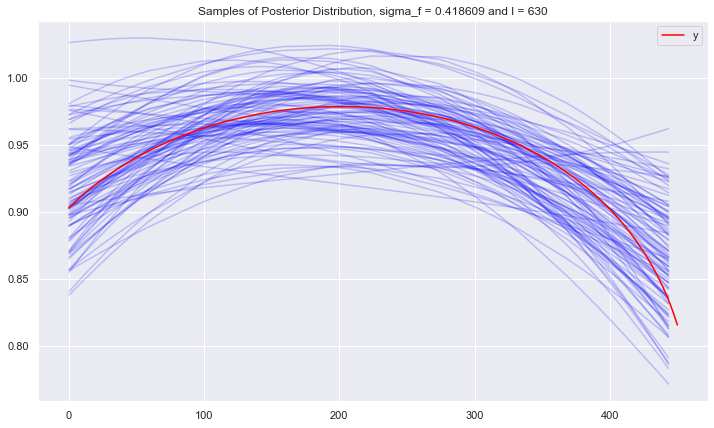

In [247]:
# Prior distribution sampling

fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_star.squeeze(), cov=sigma_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=y, color='red', label = 'y', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

Text(0.5, 0, 'window interval with prediction of 50 observations')

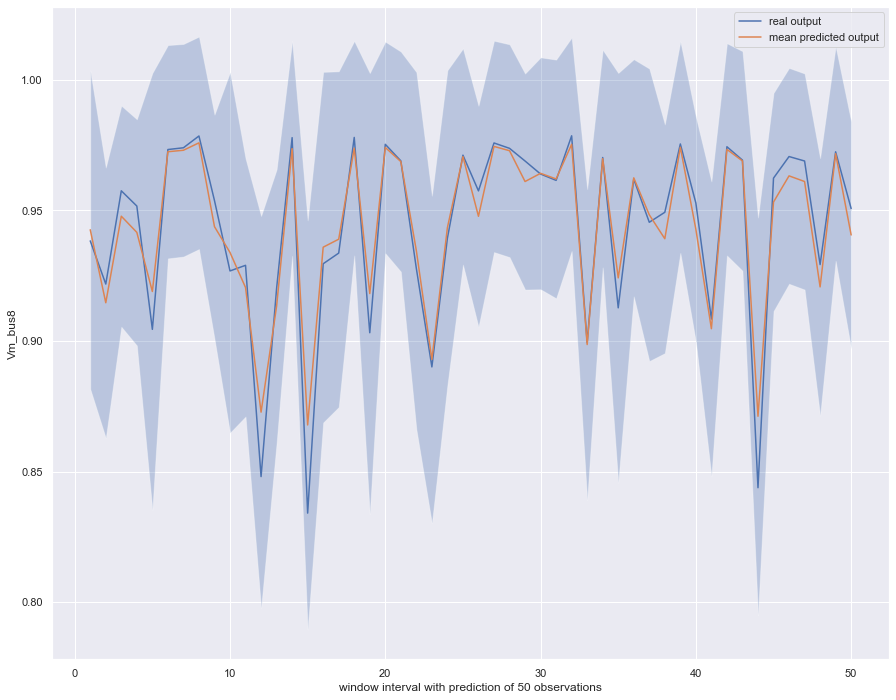

In [248]:
std = np.diag(sigma_star)
std = np.sqrt(std)
std

plt.figure(figsize=(15,12))

plt.plot(np.arange(1,51),  y_test, label='real output')
plt.plot(np.arange(1,51), mean_star, label='mean predicted output')
plt.fill_between(np.arange(1,51), mean_star.ravel() + 2*std, mean_star.ravel()-2*std, alpha=0.3)
plt.legend()
plt.ylabel('Vm_bus8')
plt.xlabel('window interval with prediction of 50 observations')